# 1. Bibliotecas

In [191]:
# 1. Bibliotecas
import math
import numpy as np
import pandas as pd
import random as rd
from scipy.optimize import minimize
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn import metrics
import plotly.graph_objects as go

# 2. Lendo os Datasets

In [17]:
df_bts = pd.read_csv('../../project_files/03_processed_files/bts.csv', delimiter=',', encoding='utf-8', index_col=False)
df_train = pd.read_csv('../../project_files/03_processed_files/meds_train_alunos.csv', delimiter=',', encoding='utf-8', index_col=False)

## 2.1 alterando os datasets

In [19]:
# dropando colunas que não serão usadas
df_bts = df_bts.iloc[:, 2:].drop(columns=['id_bts', 'nom_bts', 'nom_canal_controle_bts'])
df_train = df_train.iloc[:,2:]
# adicionando uma coluna para as distancias reais que serão preditas
df_train['rd_1'] = 0.0 # distância real para as bts de setor 1
df_train['rd_2'] = 0.0 # distância real para as bts de setor 2
df_train['rd_3'] = 0.0 # distância real para as bts de setor 3

In [20]:
def ED(lat1 : float, lon1 : float, lat2 : float, lon2 : float): #  coordenadas dos pontos e das torres
  """Calcula a distância em quilômetros entre as coordenadas de um dos pontos e uma das torres
  usando a distância haversine"""
  earth_radius = 6371.0 * 1000

  # Converte latitude e longitude de graus para radianos
  lat1_rad = math.radians(lat1)
  lon1_rad = math.radians(lon1)
  lat2_rad = math.radians(lat2)
  lon2_rad = math.radians(lon2)

  # Fórmula Haversine
  dlat = lat2_rad - lat1_rad
  dlon = lon2_rad - lon1_rad
  a = math.sin(dlat / 2)**2 + math.cos(lat1_rad) * math.cos(lat2_rad) * math.sin(dlon / 2)**2
  c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

  # Calcula a distância
  distance = earth_radius * c

  return distance

In [21]:
for i in range(df_train.shape[0]):
  df_train.loc[i, 'rd_1'] = ED(df_train.loc[i, 'num_lat_bts'], df_train.loc[i, 'num_long_bts'], df_bts.loc[0, 'num_lat_bts'], df_bts.loc[0, 'num_long_bts']) 
  df_train.loc[i, 'rd_2'] = ED(df_train.loc[i, 'num_lat_bts'], df_train.loc[i, 'num_long_bts'], df_bts.loc[3, 'num_lat_bts'], df_bts.loc[3, 'num_long_bts'])
  df_train.loc[i, 'rd_3'] = ED(df_train.loc[i, 'num_lat_bts'], df_train.loc[i, 'num_long_bts'], df_bts.loc[6, 'num_lat_bts'], df_bts.loc[6, 'num_long_bts'])

In [22]:
df_train

,id_ponto,rssi_1_1,rssi_1_2,rssi_1_3,rssi_2_1,rssi_2_2,rssi_2_3,rssi_3_1,rssi_3_2,rssi_3_3,delay_1,delay_2,delay_3,num_lat_bts,num_long_bts,flag_indoor,rd_1,rd_2,rd_3
0,6604,-103.705000,-110.425000,-107.381667,-110.330000,-108.345000,-106.590000,-107.153333,-102.120000,-115.0000,5.0,3.0,2.0,-8.055786,-34.951505,1,1376.116069,818.323014,705.979147
1,5515,-105.225000,-115.000000,-105.210000,-115.000000,-105.835000,-115.000000,-88.470000,-94.024286,-108.1200,5.0,3.0,2.0,-8.055784,-34.951608,1,1375.491341,828.673816,694.653615
2,5049,-102.610000,-115.000000,-101.380000,-115.000000,-104.295000,-97.360000,-96.980000,-99.572500,-115.0000,5.0,3.0,2.0,-8.055506,-34.951693,1,1344.326875,825.918687,683.689740
3,8737,-89.140000,-97.251429,-86.642857,-96.036667,-96.592500,-92.460000,-86.813333,-102.688000,-87.2700,4.0,7.0,2.0,-8.050390,-34.959630,0,1142.968177,1670.154895,580.338100
4,1203,-109.088333,-107.200000,-107.010000,-108.430000,-104.845714,-101.435714,-103.065000,-102.110000,-115.0000,5.0,3.0,2.0,-8.055380,-34.951736,1,1330.208922,825.547524,678.675535
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6758,5734,-105.225000,-115.000000,-105.210000,-115.000000,-105.835000,-115.000000,-93.005000,-97.114286,-108.1200,5.0,3.0,2.0,-8.055784,-34.951608,1,1375.491341,828.673816,694.653615
6759,5191,-105.225000,-115.000000,-105.210000,-115.000000,-105.835000,-115.000000,-87.315000,-88.735714,-108.1200,5.0,3.0,2.0,-8.055784,-34.951608,1,1375.491341,828.673816,694.653615
6760,5390,-105.225000,-115.000000,-105.210000,-115.000000,-105.835000,-115.000000,-95.165000,-90.705714,-108.1200,5.0,3.0,2.0,-8.055784,-34.951608,1,1375.491341,828.673816,694.653615
6761,860,-109.088333,-107.200000,-107.010000,-108.430000,-97.200000,-98.148571,-99.840000,-94.665000,-115.0000,5.0,3.0,2.0,-8.055380,-34.951736,1,1330.208922,825.547524,678.675535


In [29]:
## 2.2 Separando os dados para submeter arquivo
ind_rem = rd.sample(range(df_train.shape[0]), int(df_train.shape[0] * 0.1))
rem_df = pd.DataFrame(columns=df_train.columns)
rem_data, init_data = [], []

In [30]:
for i in range(df_train.shape[0]):
  data = dict()
  for c,v in zip(list(df_train.columns), df_train.loc[i,:]):
    data[c] = v
  if df_train.loc[i, 'id_ponto'] in ind_rem:
    rem_data.append(data)
  else:
    init_data.append(data)

In [39]:
df_train = pd.DataFrame(columns=df_train.columns, data=init_data)
rem_df = pd.DataFrame(columns=df_train.columns, data=rem_data)

# 3. Separando os Dados

In [101]:
X = df_train.drop(columns=['id_ponto','num_lat_bts', 'num_long_bts', 'rd_1', 'rd_2', 'rd_3'])
X_columns = X.columns
tv = [] # train vector composed of X_train, X_test, y_train, y_test for each bts cluster
for i in range(3):
  X_train, X_test, y_train, y_test = train_test_split(X.values, df_train.iloc[:, 16 + i], test_size=0.25, random_state=13)
  tv.append((X_train, X_test, y_train, y_test))

# 4. Funções Auxiliares

In [132]:
def lat_lon_to_rectangular(lat, lon):
    # Radius of the Earth (mean value) in meters
    earth_radius = 6371000.0
    
    # Convert latitude and longitude from degrees to radians
    lat_rad = math.radians(lat)
    lon_rad = math.radians(lon)
    
    # Calculate x and y coordinates using Mercator projection
    x = earth_radius * lon_rad
    y = earth_radius * math.log(math.tan(math.pi / 4 + lat_rad / 2))
    
    return x, y
def rectangular_to_lat_lon(x, y):
    # Radius of the Earth (mean value) in meters
    earth_radius = 6371000.0
    
    # Calculate latitude
    lat_rad = math.atan(math.exp(y / earth_radius))
    latitude = math.degrees(2 * lat_rad - math.pi / 2)
    
    # Calculate longitude
    longitude = math.degrees(x / earth_radius)
    
    return latitude, longitude

def calculate_coordinates(bts, dists):
  def optf(args, bts, dists): # optimize function
    soma = 0
    r, theta = args
    for i in range(len(bts)):
      xi,yi, _ = bts[i]
      d = dists[i]
      soma += abs(d - math.sqrt((r * math.cos(theta) - xi)**2 + ((r * math.sin(theta) - yi)**2)))
    return -soma
  
  # define constraints
  r_min, r_max = bts[0][2] * 234, (bts[0][2]+1) * 234
  
  # define constraints for r
  constraints = (
    {'type': 'ineq', 'fun': lambda params: params[0] - r_min},  # r >= r_min
    {'type': 'ineq', 'fun': lambda params: r_max - params[0]},  # r <= r_max
  )

  # Define initial guess for r and beta
  initial_guess = [1.0, 0.0]
  # Call the minimize function
  result = minimize(optf, initial_guess, args=(bts, dists), constraints=constraints, method='SLSQP')
  # Extract the optimized values of r and beta
  optimized_r, optimized_beta = result.x
  return optimized_r, optimized_beta

In [133]:
bts_cords = [
  [*lat_lon_to_rectangular(df_bts.loc[0, 'num_lat_bts'], df_bts.loc[0, 'num_long_bts']), 0.0],
  [*lat_lon_to_rectangular(df_bts.loc[3, 'num_lat_bts'],df_bts.loc[3, 'num_long_bts']), 0.0],
  [*lat_lon_to_rectangular(df_bts.loc[6, 'num_lat_bts'],df_bts.loc[6, 'num_long_bts']), 0.0]
]

In [134]:
bts_cords

[[-3886485.0760806166, -897339.7762058176, 0.0],
 [-3885670.2396581653, -898403.2667475431, 0.0],
 [-3887141.12614782, -898676.1622042521, 0.0]]

# 5. Treinando o Modelo

In [102]:
modelos = []
for X_train, X_test, y_train, y_test in tv:
    t = RandomForestRegressor(max_depth=15).fit(X_train, y_train)
    modelos.append(t)
    # yhat = t.predict(X_test)
    # print(metrics.mean_squared_error(y_test, yhat))

# 6. Computando as localizações

In [49]:
submit_df = pd.DataFrame(columns= ['ex_lat, ex_lon, pred_lat, pred_lon']) # datafram pra armazena os valores originais e os preditos
result_data = []

In [147]:
def main():
  result_data = []
  for i in range(2):
    row_train_values = np.array(df_train.loc[i, X_columns]).reshape(1,-1)
    # print(row_train_values)
    pred1, pred2, pred3 = modelos[0].predict(row_train_values), modelos[1].predict(row_train_values), modelos[2].predict(row_train_values)
    bts_cords[0][2] = df_train.loc[i, 'delay_1']
    best_r, best_angle = calculate_coordinates(bts_cords, [pred1, pred2, pred3])
    print(best_r, best_angle)
    pred_x, pred_y = bts_cords[0][0] + best_r * math.sin(best_angle), bts_cords[0][1] + best_r * math.cos(best_angle)
    pred_lat, pred_lon = rectangular_to_lat_lon(pred_x, pred_y)
    result_data.append({
      'ex_lat' : df_train.loc[i, 'num_lat_bts'],
      'ex_lon' : df_train.loc[i, 'num_long_bts'],
      'pred_lat' : pred_lat,
      'pred_lon' : pred_lon
    })

In [142]:
main()

1404.0000000002292 0.22710875725272392
1170.0000000016246 0.22714592154271804


In [143]:
result_data

[{'ex_lat': -8.055506,
  'ex_lon': -34.951693,
  'pred_lat': -12.678494972074743,
  'pred_lon': -103.00084184602918},
 {'ex_lat': -8.05039,
  'ex_lon': -34.95963,
  'pred_lat': -12.678531041091304,
  'pred_lon': -103.00088073739781},
 {'ex_lat': -8.05578,
  'ex_lon': -34.95639,
  'pred_lat': -12.678459193897654,
  'pred_lon': -103.0008032682747},
 {'ex_lat': -8.049710000000001,
  'ex_lon': -34.954640000000005,
  'pred_lat': -12.678566837238064,
  'pred_lon': -103.00091933456187},
 {'ex_lat': -8.055494,
  'ex_lon': -34.951316,
  'pred_lat': -12.678495310511758,
  'pred_lon': -103.00084221094835},
 {'ex_lat': -8.055684,
  'ex_lon': -34.951331,
  'pred_lat': -12.678495141384937,
  'pred_lon': -103.00084202858761},
 {'ex_lat': -8.055833999999999,
  'ex_lon': -34.951362,
  'pred_lat': -12.678495134160512,
  'pred_lon': -103.00084202079789},
 {'ex_lat': -8.05625,
  'ex_lon': -34.95713,
  'pred_lat': -12.67845934116914,
  'pred_lon': -103.00080342706988},
 {'ex_lat': -8.05402,
  'ex_lon': -34

# 7. Criando o submit_alunos

In [170]:
error_data = []
result_data = []
comp_data = []

In [186]:
def main():
  for i in range(rem_df.shape[0]):
    row_train_values = np.array(rem_df.loc[i, X_columns]).reshape(1,-1)
    # print(row_train_values)
    pred1, pred2, pred3 = modelos[0].predict(row_train_values), modelos[1].predict(row_train_values), modelos[2].predict(row_train_values)
    bts_cords[0][2] = rem_df.loc[i, 'delay_1']
    best_r, best_angle = calculate_coordinates(bts_cords, [pred1, pred2, pred3])
    # print(best_r, best_angle)
    pred_x, pred_y = bts_cords[0][0] + best_r * math.sin(best_angle), bts_cords[0][1] + best_r * math.cos(best_angle)
    pred_lat, pred_lon = rectangular_to_lat_lon(pred_x, pred_y)
    result_data.append({
      'ponto_id' : rem_df.loc[i, 'id_ponto'],
      'lat' : pred_lat,
      'lon' : pred_lon
    })
    error_data.append({
      'ponto_id' : rem_df.loc[i, 'id_ponto'],
      'erro(metros)' : ED(pred_lat, pred_lon, rem_df.loc[i, 'num_lat_bts'], rem_df.loc[i, 'num_long_bts'])
    })
    comp_data.append({
      'ponto_id' : rem_df.loc[i, 'id_ponto'],
      'pred_lat' : pred_lat,
      'pred_lon' : pred_lon,
      'orig_lat' : rem_df.loc[i, 'num_lat_bts'],
      'orig_lon': rem_df.loc[i, 'num_long_bts']
    })

In [187]:
error_data = []
result_data = []
comp_data = []
main()

In [173]:
result_data

[{'ponto_id': 6604.0, 'lat': -8.03123861586675, 'lon': -34.94915692087077},
 {'ponto_id': 5515.0, 'lat': -8.031238592366611, 'lon': -34.94915702356696},
 {'ponto_id': 1203.0, 'lat': -8.031238596193251, 'lon': -34.94915700684417},
 {'ponto_id': 3519.0, 'lat': -8.031238592366611, 'lon': -34.94915702356696},
 {'ponto_id': 4607.0, 'lat': -8.031238596783105, 'lon': -34.94915700426645},
 {'ponto_id': 4309.0, 'lat': -8.031238578175575, 'lon': -34.949157085583984},
 {'ponto_id': 2706.0, 'lat': -8.03123860369842, 'lon': -34.9491569740463},
 {'ponto_id': 5935.0, 'lat': -8.03123861586675, 'lon': -34.94915692087077},
 {'ponto_id': 4128.0, 'lat': -8.031238578175575, 'lon': -34.949157085583984},
 {'ponto_id': 5627.0, 'lat': -8.031238592366611, 'lon': -34.94915702356696},
 {'ponto_id': 5403.0, 'lat': -8.031238592366611, 'lon': -34.94915702356696},
 {'ponto_id': 2449.0, 'lat': -8.03123860369842, 'lon': -34.9491569740463},
 {'ponto_id': 5316.0, 'lat': -8.031238592366611, 'lon': -34.94915702356696},
 {'

In [166]:
submit_df = pd.DataFrame(columns=['ponto_id', 'lat', 'lon'], data=result_data)
submit_df

,ponto_id,lat,lon
0,6604.0,-8.031239,-34.949157
1,5515.0,-8.031239,-34.949157
2,1203.0,-8.031239,-34.949157
3,3519.0,-8.031239,-34.949157
4,4607.0,-8.031239,-34.949157
...,...,...,...
432,769.0,-8.031239,-34.949157
433,1685.0,-8.031239,-34.949157
434,4426.0,-8.031239,-34.949157
435,466.0,-8.031239,-34.949157


In [169]:
submit_df.to_csv('../../project_files/output/submit_alunos_trilateracao.csv', sep=';')

# 8. Gráficos do train

In [182]:
df_diff = pd.DataFrame(columns=['ponto_id', 'erro(metros)'], data=error_data)

In [184]:
df_diff.describe()

,ponto_id,erro(metros)
count,437.000000,437.000000
mean,3371.823799,2733.925297
std,1955.087493,91.266456
min,9.000000,2699.377051
25%,1704.000000,2707.534356
50%,3351.000000,2724.167902
75%,5121.000000,2741.760242
max,6730.000000,3568.178457


<AxesSubplot:>

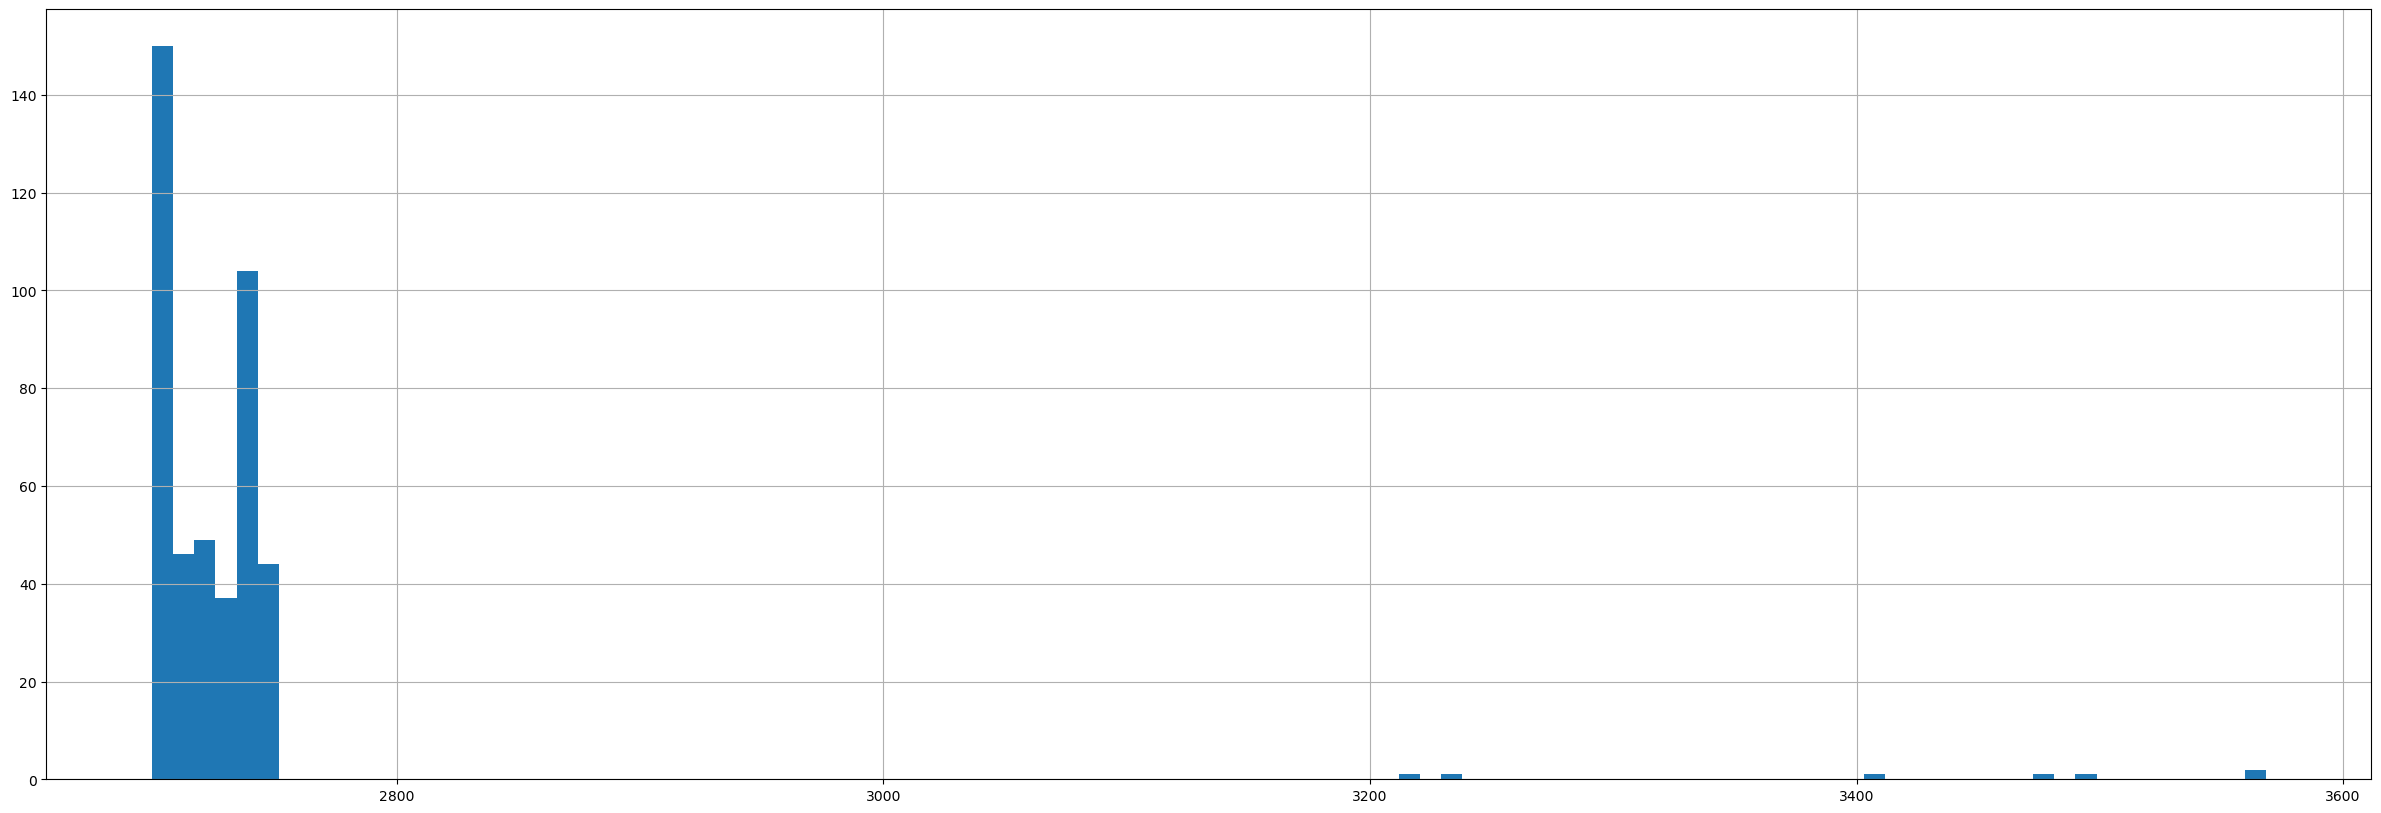

In [183]:
# histograma
df_diff['erro(metros)'].hist(bins=100,figsize=(30,10))

<AxesSubplot:>

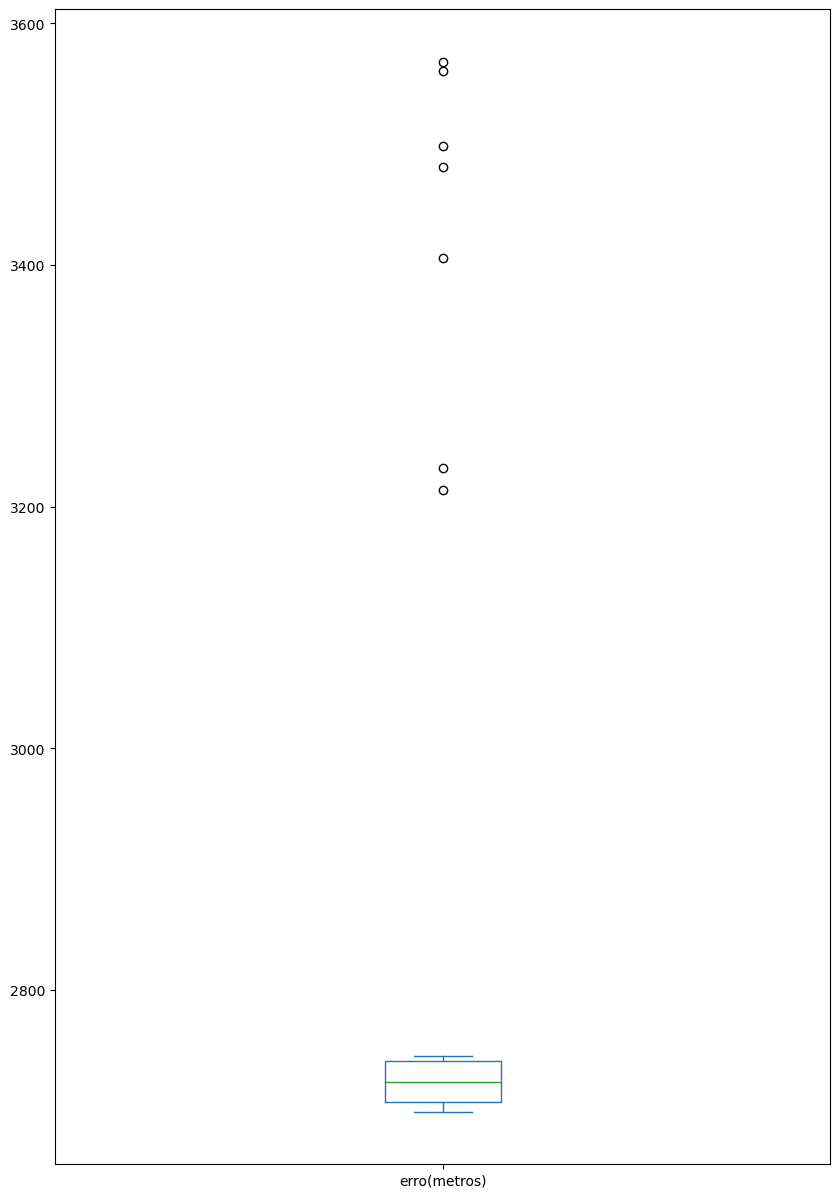

In [185]:
# boxplot
df_diff['erro(metros)'].plot(kind='box',figsize=(10,15))

In [189]:
comp_df = pd.DataFrame(columns=comp_data[0].keys(), data=comp_data)
comp_df

,ponto_id,pred_lat,pred_lon,orig_lat,orig_lon
0,6604.0,-8.031239,-34.949157,-8.055786,-34.951505
1,5515.0,-8.031239,-34.949157,-8.055784,-34.951608
2,1203.0,-8.031239,-34.949157,-8.055380,-34.951736
3,3519.0,-8.031239,-34.949157,-8.055834,-34.951362
4,4607.0,-8.031239,-34.949157,-8.055506,-34.951693
...,...,...,...,...,...
432,769.0,-8.031239,-34.949157,-8.055605,-34.951728
433,1685.0,-8.031239,-34.949157,-8.055494,-34.951316
434,4426.0,-8.031239,-34.949157,-8.055506,-34.951693
435,466.0,-8.031239,-34.949157,-8.055605,-34.951728


/tmp/ipykernel_39896/4042514183.py:14: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


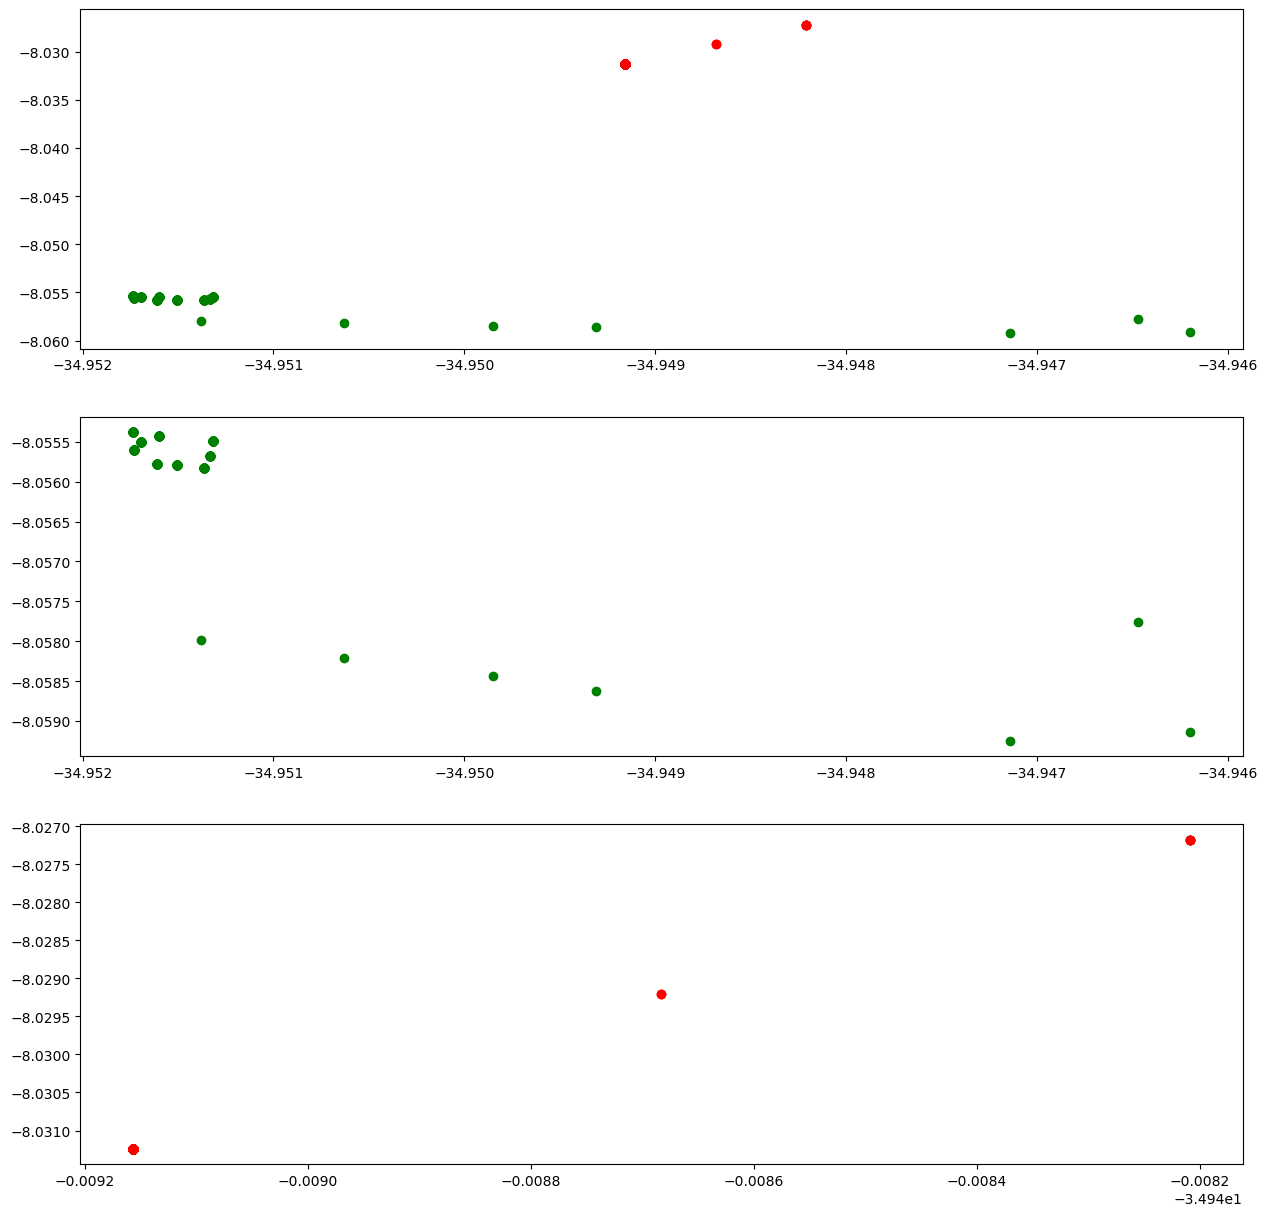

In [190]:
fig, (ax1, ax2, ax3) = plt.subplots(3,figsize=(15,15))
ax1.scatter(comp_df['orig_lon'],comp_df['orig_lat'], c='green')
ax1.scatter(comp_df['pred_lon'],comp_df['pred_lat'], c='red')
#ax1.title('Mapa de comparação:')
#ax1.legend(["reais","preditas"])

ax2.scatter(comp_df['orig_lon'],comp_df['orig_lat'], c='green')
#ax2.title('Reais:')

ax3.scatter(comp_df['pred_lon'],comp_df['pred_lat'], c='red')
#ax3.title('Preditas')


fig.show()

# 8. Testing the test file

In [196]:
# training a model to predict if indoor or not
X = df_train.drop(columns=['id_ponto','num_lat_bts', 'num_long_bts', 'rd_1', 'rd_2', 'rd_3', 'flag_indoor'])
X_columns = X.columns
X_train, X_test, y_train, y_test = train_test_split(X.values, df_train['flag_indoor'], test_size=0.25, random_state=13)
model = RandomForestClassifier(max_depth=15).fit(X_train, y_train)
yhat = model.predict(X_test)
print(f'acc: {metrics.accuracy_score(y_test, yhat)}')

acc: 1.0


In [226]:
df_test = pd.read_csv('../../project_files/03_processed_files/meds_test_alunos.csv', sep=',')
df_test = df_test.loc[:, 'id_ponto':]

In [243]:
X_columns = df_test.drop(columns=['id_ponto','num_lat_bts', 'num_long_bts']).columns

In [231]:
df_test

,id_ponto,rssi_1_1,rssi_1_2,rssi_1_3,rssi_2_1,rssi_2_2,rssi_2_3,rssi_3_1,rssi_3_2,rssi_3_3,delay_1,delay_2,delay_3,num_lat_bts,num_long_bts,flag_indoor
0,0,-103.705000,-110.425000,-107.381667,-110.330000,-108.345000,-106.590000,-107.153333,-102.120000,-115.00,5.0,3.0,2.0,-8.055786,-34.951505,1.0
1,3,-105.225000,-115.000000,-105.210000,-115.000000,-105.835000,-115.000000,-88.470000,-94.024286,-108.12,5.0,3.0,2.0,-8.055784,-34.951608,1.0
2,8,-102.610000,-115.000000,-101.380000,-115.000000,-104.295000,-97.360000,-96.980000,-99.572500,-115.00,5.0,3.0,2.0,-8.055506,-34.951693,1.0
3,10,-89.140000,-97.251429,-86.642857,-96.036667,-96.592500,-92.460000,-86.813333,-102.688000,-87.27,5.0,3.0,2.0,-8.050390,-34.959630,0.0
4,12,-109.088333,-107.200000,-107.010000,-108.430000,-104.845714,-101.435714,-103.065000,-102.110000,-115.00,5.0,3.0,2.0,-8.055380,-34.951736,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2894,9672,-106.070000,-115.000000,-106.670000,-104.161667,-97.531429,-93.390000,-96.125714,-96.436667,-115.00,1.0,4.0,4.0,-8.055424,-34.951597,1.0
2895,9674,-100.830000,-115.000000,-98.560000,-115.000000,-100.406667,-97.845714,-99.255000,-98.118000,-115.00,1.0,4.0,4.0,-8.055834,-34.951362,1.0
2896,9675,-101.196667,-115.000000,-96.040000,-115.000000,-96.790000,-96.100000,-94.420000,-93.024000,-115.00,1.0,4.0,4.0,-8.055506,-34.951693,1.0
2897,9677,-109.088333,-107.200000,-107.010000,-108.430000,-98.651429,-100.040000,-101.130000,-96.545000,-115.00,1.0,4.0,5.0,-8.055380,-34.951736,1.0


In [229]:
predict_indoor = model.predict(df_test.loc[:,'rssi_1_1':'delay_3'].values)
predict_indoor

array([1., 1., 1., ..., 1., 1., 1.])

In [230]:
df_test['flag_indoor'] = predict_indoor

In [244]:
X_columns

Index(['rssi_1_1', 'rssi_1_2', 'rssi_1_3', 'rssi_2_1', 'rssi_2_2', 'rssi_2_3',
       'rssi_3_1', 'rssi_3_2', 'rssi_3_3', 'delay_1', 'delay_2', 'delay_3',
       'flag_indoor'],
      dtype='object')

In [246]:
def main():
  for i in range(df_test.shape[0]):
    row_train_values = df_test.loc[i, X_columns].values.reshape(1,-1)
    # print(row_train_values)
    pred1, pred2, pred3 = modelos[0].predict(row_train_values), modelos[1].predict(row_train_values), modelos[2].predict(row_train_values)
    bts_cords[0][2] = df_test.loc[i, 'delay_1']
    best_r, best_angle = calculate_coordinates(bts_cords, [pred1, pred2, pred3])
    # print(best_r, best_angle)
    pred_x, pred_y = bts_cords[0][0] + best_r * math.sin(best_angle), bts_cords[0][1] + best_r * math.cos(best_angle)
    pred_lat, pred_lon = rectangular_to_lat_lon(pred_x, pred_y)
    result_data.append({
      'ponto_id' : df_test.loc[i, 'id_ponto'],
      'lat' : pred_lat,
      'lon' : pred_lon
    })
    error_data.append({
      'ponto_id' : df_test.loc[i, 'id_ponto'],
      'erro(metros)' : ED(pred_lat, pred_lon, df_test.loc[i, 'num_lat_bts'], df_test.loc[i, 'num_long_bts'])
    })
    comp_data.append({
      'ponto_id' : df_test.loc[i, 'id_ponto'],
      'pred_lat' : pred_lat,
      'pred_lon' : pred_lon,
      'orig_lat' : df_test.loc[i, 'num_lat_bts'],
      'orig_lon': df_test.loc[i, 'num_long_bts']
    })

In [247]:
result_data = []
error_data = []
comp_data = []
main()

In [248]:
submit_df = pd.DataFrame(columns=['ponto_id', 'lat', 'lon'], data=result_data)
submit_df

,ponto_id,lat,lon
0,0,-8.031239,-34.949157
1,3,-8.031239,-34.949157
2,8,-8.031239,-34.949157
3,10,-8.031239,-34.949157
4,12,-8.031239,-34.949157
...,...,...,...
2894,9672,-8.039360,-34.951052
2895,9674,-8.039360,-34.951052
2896,9675,-8.039360,-34.951052
2897,9677,-8.039360,-34.951052


In [249]:
submit_df.to_csv('../../project_files/output/Resultados_Equipe01_MetodoTrilateracao.csv', sep=';')